<a href="https://colab.research.google.com/github/Yusuf-Abdullatif01/ENGG680_2025_Fall/blob/main/Project__ENGG__680.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

In [ ]:
CSV_path="/content/drive/MyDrive/Colab Notebooks/ENGG680_Final_Project/Historical_Air_Quality_20250925.csv"
df=pd.read_csv(CSV_path)
df.head()

,Station Name,Date,Method,Parameter,Average Daily Value,Units,Location,Count,ID
0,Calgary Central-Inglewood,2019/09/30,Instrumental,Carbon Monoxide,0.1826,ppm,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Carbon Mo...
1,Calgary Central-Inglewood,2019/09/30,Instrumental,Outdoor Air Temperature,0.0000,deg c,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Outdoor A...
2,Calgary Southeast,2019/09/30,Instrumental,Wind Speed,7.7792,km/hr 10m,"(50.955122, -113.969742)",1,2019-09-30-Calgary Southeast-Wind Speed-7.7792
3,Calgary Central-Inglewood,2019/09/30,Instrumental,Methane,2.0435,ppm,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Methane-2...
4,Calgary Central-Inglewood,2019/09/30,Calculated,Air Quality Index,1.4003,NaN,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Air Quali...


In [ ]:
# Filtering the dataset

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
core_params = [
    "PM2.5 Mass","PM10 Mass","Nitrogen Dioxide","Ozone","Carbon Monoxide","Sulphur Dioxide",
    "Outdoor Air Temperature","Relative Humidity","Wind Speed"
]
df_core = df[df['Parameter'].isin(core_params)].copy()

daily = (
    df_core.groupby(['Date','Parameter'])['Average Daily Value']
    .mean()
    .unstack('Parameter') # Changing the format of the dataset to a wider format better for Decscion trees
    .sort_index()
)

rename_map = {
    "PM2.5 Mass":"PM25","PM10 Mass":"PM10","Nitrogen Dioxide":"NO2","Ozone":"O3",
    "Carbon Monoxide":"CO","Sulphur Dioxide":"SO2","Outdoor Air Temperature":"Temp",
    "Relative Humidity":"RH","Wind Speed":"WindSpd"
}
daily.rename(columns=rename_map, inplace=True) #Renaming some of the variables

df_core.head(140000)




,Station Name,Date,Method,Parameter,Average Daily Value,Units,Location,Count,ID
0,Calgary Central-Inglewood,2019-09-30,Instrumental,Carbon Monoxide,0.1826,ppm,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Carbon Mo...
1,Calgary Central-Inglewood,2019-09-30,Instrumental,Outdoor Air Temperature,0.0000,deg c,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Outdoor A...
2,Calgary Southeast,2019-09-30,Instrumental,Wind Speed,7.7792,km/hr 10m,"(50.955122, -113.969742)",1,2019-09-30-Calgary Southeast-Wind Speed-7.7792
5,Calgary Central-Inglewood,2019-09-30,Instrumental,Ozone,0.0000,ppb,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-Ozone-0.0
6,Calgary Central-Inglewood,2019-09-30,Sharp (hybrid nephelometer/BAM sys),PM2.5 Mass,4.0833,ug/m3,"(51.029944, -114.008111)",1,2019-09-30-Calgary Central-Inglewood-PM2.5 Mas...
...,...,...,...,...,...,...,...,...,...
307704,Calgary Central,1994-03-27,Instrumental,Nitrogen Dioxide,0.0304,ppm,"(51.0471506, -114.0731477)",1,1994-03-27-Calgary Central-Nitrogen Dioxide-0....
307707,Calgary Central,1994-03-27,Instrumental,Ozone,0.0187,ppm,"(51.0471506, -114.0731477)",1,1994-03-27-Calgary Central-Ozone-0.0187
307710,Calgary East,1994-03-27,Instrumental,Ozone,0.0136,ppm,"(51.009444, -114.025278)",1,1994-03-27-Calgary East-Ozone-0.0136
307713,Calgary East,1994-03-27,Instrumental,Carbon Monoxide,0.7125,ppm,"(51.009444, -114.025278)",1,1994-03-27-Calgary East-Carbon Monoxide-0.7125


In [ ]:
#Feature Engineering

"""
LAG FEATURES:
Lag features give the model a simple kind of "memory" about what happened
on previous days. For example, PM25_lag1 means "PM2.5 yesterday",
PM25_lag2 means "two days ago", and PM25_lag7 means "one week ago".
This is important because air pollution usually follows patterns over time.
By giving the model access to yesterday’s and last week's values, it can make
much smarter predictions about tomorrow.
"""

"""
ROLLING AVERAGE FEATURES:
Rolling features represent the average value over a recent window of days.
For example, PM25_roll3 is the average PM2.5 from the last 3 days, and
PM25_roll7 is the average over the last 7 days. These features smooth out
the day-to-day noise and help the model understand recent trends—whether
pollution has been rising or falling. Tree-based models like RandomForest
and XGBoost learn much better when these trend features are included.
"""

def add_lags_rolls(df_in, cols, lags=(1,2,3,7), rolls=(3,7)):
    df_out = df_in.copy()
    for c in cols:
        if c in df_out.columns:
            for L in lags:
                df_out[f"{c}_lag{L}"] = df_out[c].shift(L)
            for R in rolls:
                df_out[f"{c}_roll{R}"] = df_out[c].rolling(R).mean()
    return df_out

key_cols = ["PM25","NO2","O3","CO","SO2","PM10","Temp","RH","WindSpd"]
feat = add_lags_rolls(daily, key_cols)

#Target: next-day PM2.5
feat['PM25_tomorrow'] = feat['PM25'].shift(-1)

#Drop NA from lags/shift
feat_model = feat.dropna().copy()



In [ ]:
#RandomForest
n = len(feat_model)
split_idx = int(n*0.8)
train = feat_model.iloc[:split_idx]
test  = feat_model.iloc[split_idx:]

X_cols = [c for c in feat_model.columns if c != 'PM25_tomorrow']
y_col  = 'PM25_tomorrow'

X_train, y_train = train[X_cols], train[y_col]
X_test,  y_test  = test[X_cols],  test[y_col]

#6) RandomForest baseline
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2  = r2_score(y_test, rf_pred)

print(f"RandomForest  | MAE: {rf_mae:.3f} | R2: {rf_r2:.3f}")

RandomForest  | MAE: 2.952 | R2: 0.388


In [ ]:
# XGBoost comparison.
if HAS_XGB:
    xgb = XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method="hist"
    )
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_r2  = r2_score(y_test, xgb_pred)
    print(f"XGBoost       | MAE: {xgb_mae:.3f} | R2: {xgb_r2:.3f}")

#8) Save artifacts
os.makedirs("outputs", exist_ok=True)
feat_model.to_csv("outputs/calgary_air_features_daily.csv")
pd.DataFrame({
    "Date": test.index,
    "PM25_actual_tomorrow": y_test.values,
    "PM25_pred_rf": rf_pred
}).to_csv("outputs/predictions_rf.csv", index=False)

if HAS_XGB:
    pd.DataFrame({
        "Date": test.index,
        "PM25_actual_tomorrow": y_test.values,
        "PM25_pred_xgb": xgb_pred
    }).to_csv("outputs/predictions_xgb.csv", index=False)


XGBoost       | MAE: 3.076 | R2: 0.247


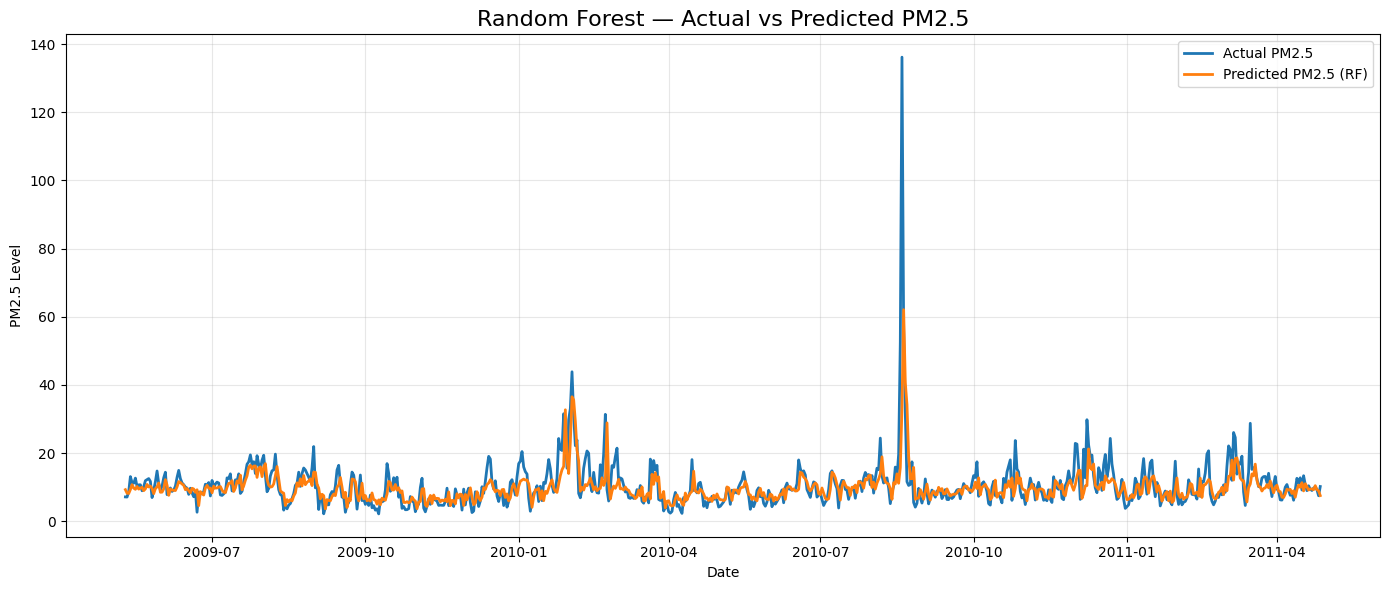

In [ ]:
# Plotting the results.
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(test.index, y_test, label='Actual PM2.5', linewidth=2)
plt.plot(test.index, rf_pred, label='Predicted PM2.5 (RF)', linewidth=2)
plt.title("Random Forest — Actual vs Predicted PM2.5", fontsize=16)
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

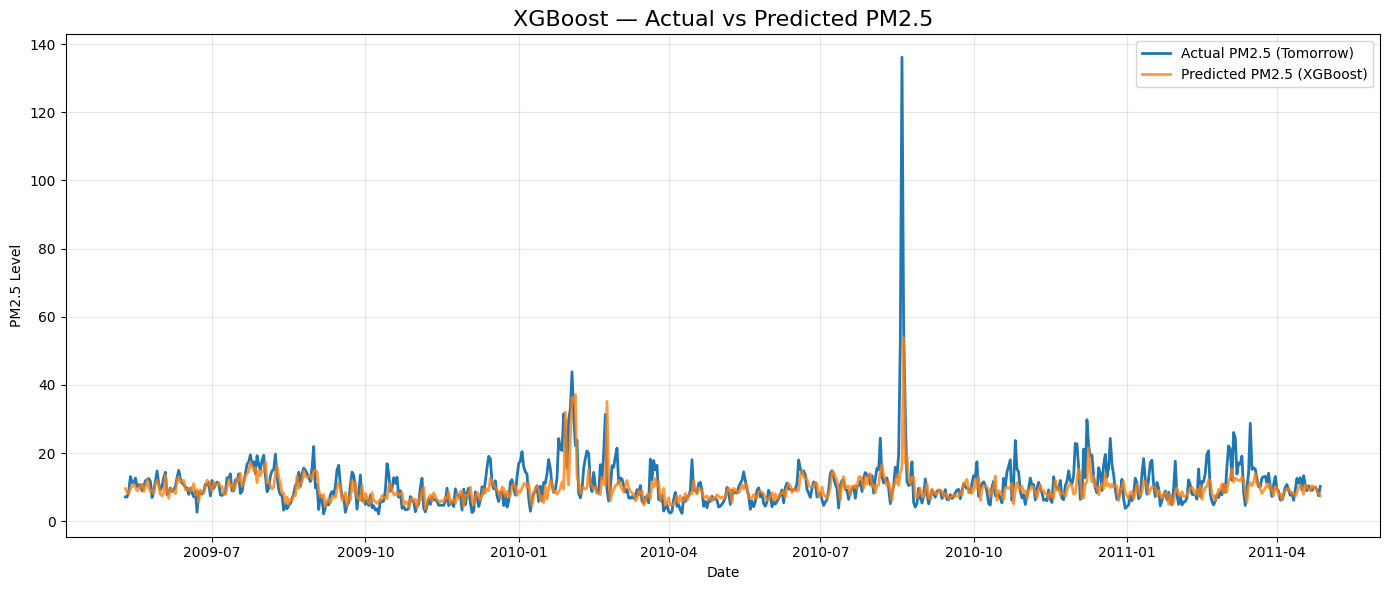

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test.index, y_test, label='Actual PM2.5 (Tomorrow)', linewidth=2)
plt.plot(test.index, xgb_pred, label='Predicted PM2.5 (XGBoost)', linewidth=2, alpha=0.8)
plt.title("XGBoost — Actual vs Predicted PM2.5", fontsize=16)
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

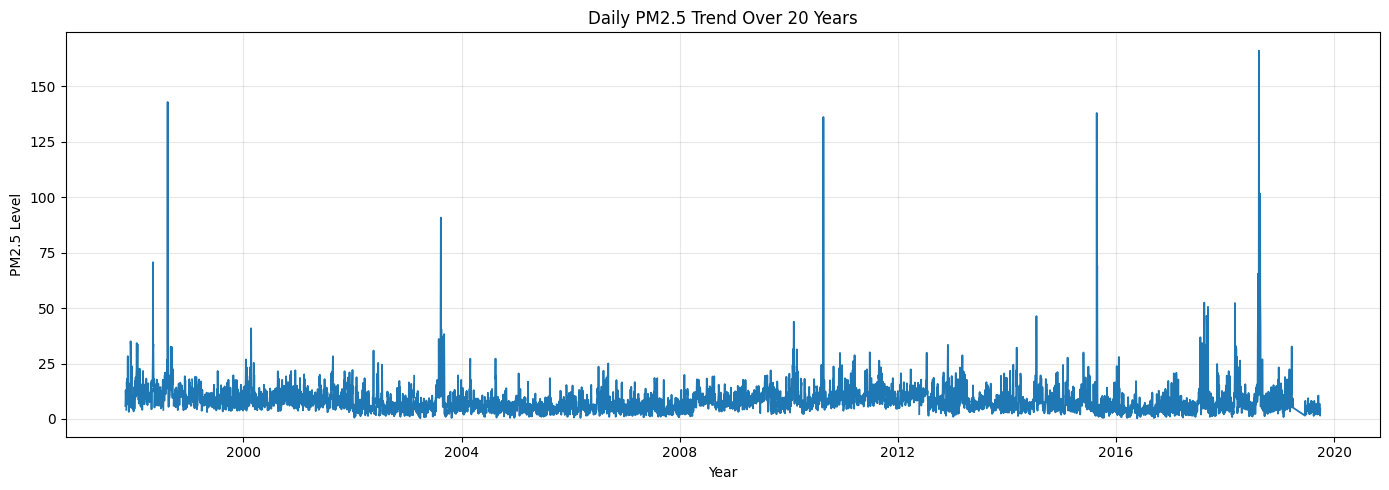

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(daily.index, daily['PM25'], linewidth=1.3)
plt.title("Daily PM2.5 Trend Over 20 Years")
plt.xlabel("Year")
plt.ylabel("PM2.5 Level")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


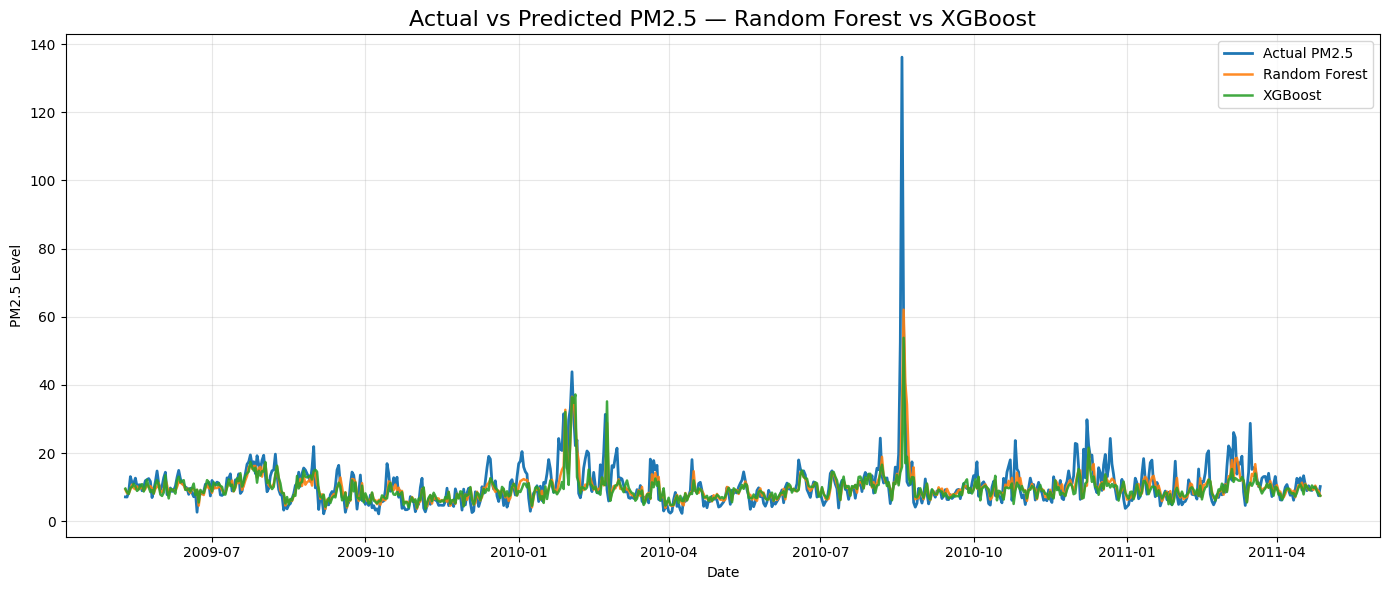

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test.index, y_test, label='Actual PM2.5', linewidth=2)
plt.plot(test.index, rf_pred, label='Random Forest', linewidth=1.8, alpha=0.9)
plt.plot(test.index, xgb_pred, label='XGBoost', linewidth=1.8, alpha=0.9)

plt.title("Actual vs Predicted PM2.5 — Random Forest vs XGBoost", fontsize=16)
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()